In [1]:
import matplotlib.pyplot as plt
import numpy as np
import mymodels
import tensorflow as tf

In [2]:
main_folder = '../'
dataset_folder = main_folder + 'dataset_tfrecord/'
dataset2_folder = main_folder + 'dataset2/'
logs_folder = main_folder + 'logs/'
checkpoints_folder = main_folder + 'checkpoints_sect1/'

In [3]:
def load_tfrecord(filename, dataset_type=tf.int32):
    parse_tensor = lambda x: tf.io.parse_tensor(x, dataset_type)
    return tf.data.TFRecordDataset(filename).map(parse_tensor)

def get_tensor(x):
    for tensor in x:
        return tensor
    
def make_tf_dataset(X, y, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

In [4]:
X = get_tensor(load_tfrecord(dataset_folder + 'train_image.tfrecord', dataset_type=tf.double))
y = get_tensor(load_tfrecord(dataset_folder + 'train_label.tfrecord', dataset_type=tf.int64))

X_test = get_tensor(load_tfrecord(dataset_folder + 'test_image.tfrecord', dataset_type=tf.double))
y_test = get_tensor(load_tfrecord(dataset_folder + 'test_label.tfrecord', dataset_type=tf.int64))

X_train_canvas = np.load(dataset_folder + 'X_train_canvas.npy')
X_test_canvas = np.load(dataset_folder + 'X_test_canvas.npy')
y_train = np.load(dataset_folder + 'y_train.npy')
y_test = np.load(dataset_folder + 'y_test.npy')

In [5]:
X_train_canvas = X.numpy()
X_test_canvas = X_test.numpy()

y_train = y.numpy()
y_test = y_test.numpy()

In [6]:
weights = checkpoints_folder + 'sect1_epoch_100.weights.h5'
model = mymodels.sect1()
model.compile()
model.load_weights(weights)

In [7]:
def crop_images(X_train_canvas):
    X_cropped = []
    crop_amount = 32
    base_grace = 5

    small_data = X_train_canvas #[:100]

    for i in range(small_data.shape[0]):
        grace = base_grace

        image = small_data[i]
        coords = model.predict(image.reshape(1, 128, 128, 1))
        x = int(coords[0][0])
        y = int(coords[0][1])
        if x > 128-crop_amount-grace:
            x = 128-crop_amount-grace
        if x < grace:
            x = grace
        if y > 128-crop_amount-grace:
            y = 128-crop_amount-grace
        if y < grace:
            y = grace
        
        cropped_image = image[y-grace:y+crop_amount+grace, x-grace:x+crop_amount+grace]

        if cropped_image.shape != (42,42,1):
            print(f"Error: {cropped_image.shape}")
            print(x,y)
            plt.imshow(cropped_image)
            plt.show()
            plt.imshow(image)
            plt.show()
        X_cropped.append(cropped_image)
        print(f"\rNum: {i+1} / {small_data.shape[0]}", end='')

    X_cropped = np.array(X_cropped)
    return X_cropped

In [8]:
X_cropped = crop_images(X_train_canvas)
X_test_cropped = crop_images(X_test_canvas)

Num: 128 / 128

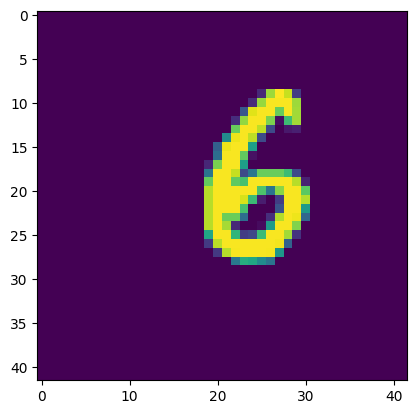

In [9]:
#show random sample
import random
rand = X_cropped[random.randint(0, X_cropped.shape[0]-1)]
plt.imshow(rand)

In [10]:
def write(X, filename):
    serialized = tf.io.serialize_tensor(X)
    record_file = filename

    with tf.io.TFRecordWriter(record_file) as writer:
        writer.write(serialized.numpy())

def write_in_batches(data, filename, batch_size=100):
    record_file = filename
    with tf.io.TFRecordWriter(record_file) as writer:
        # Iterate through the dataset in batches
        for i in range(0, len(data), batch_size):
            # Check if this batch is a full batch
            if i + batch_size <= len(data):
                batch = data[i:i + batch_size]
                serialized = tf.io.serialize_tensor(batch)
                writer.write(serialized.numpy())

In [11]:
write_in_batches(X_cropped, 'train_image_cropped.tfrecord', batch_size=512)
write_in_batches(y_train, 'train_label.tfrecord', batch_size=512)

write_in_batches(X_test_cropped, 'test_image_cropped.tfrecord', batch_size=512)
write_in_batches(y_test, 'test_label.tfrecord', batch_size=512)